# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make all Necessary Imports

import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display



In [7]:
# Unzip the data
with zipfile.ZipFile("./data/unlabelled_sounds.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

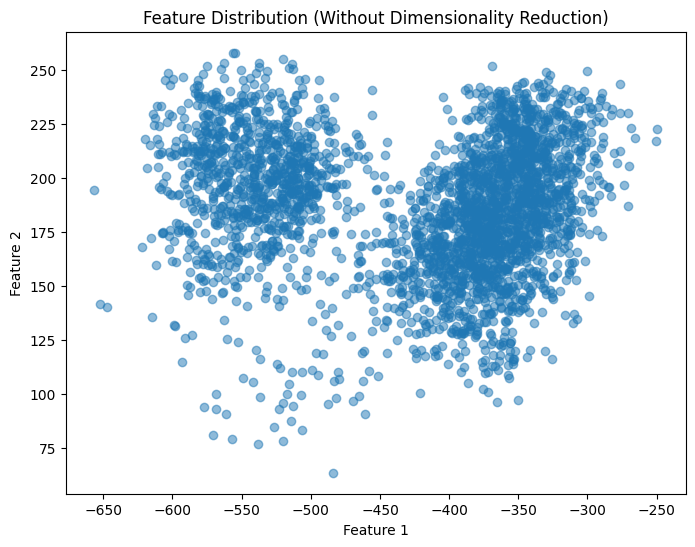

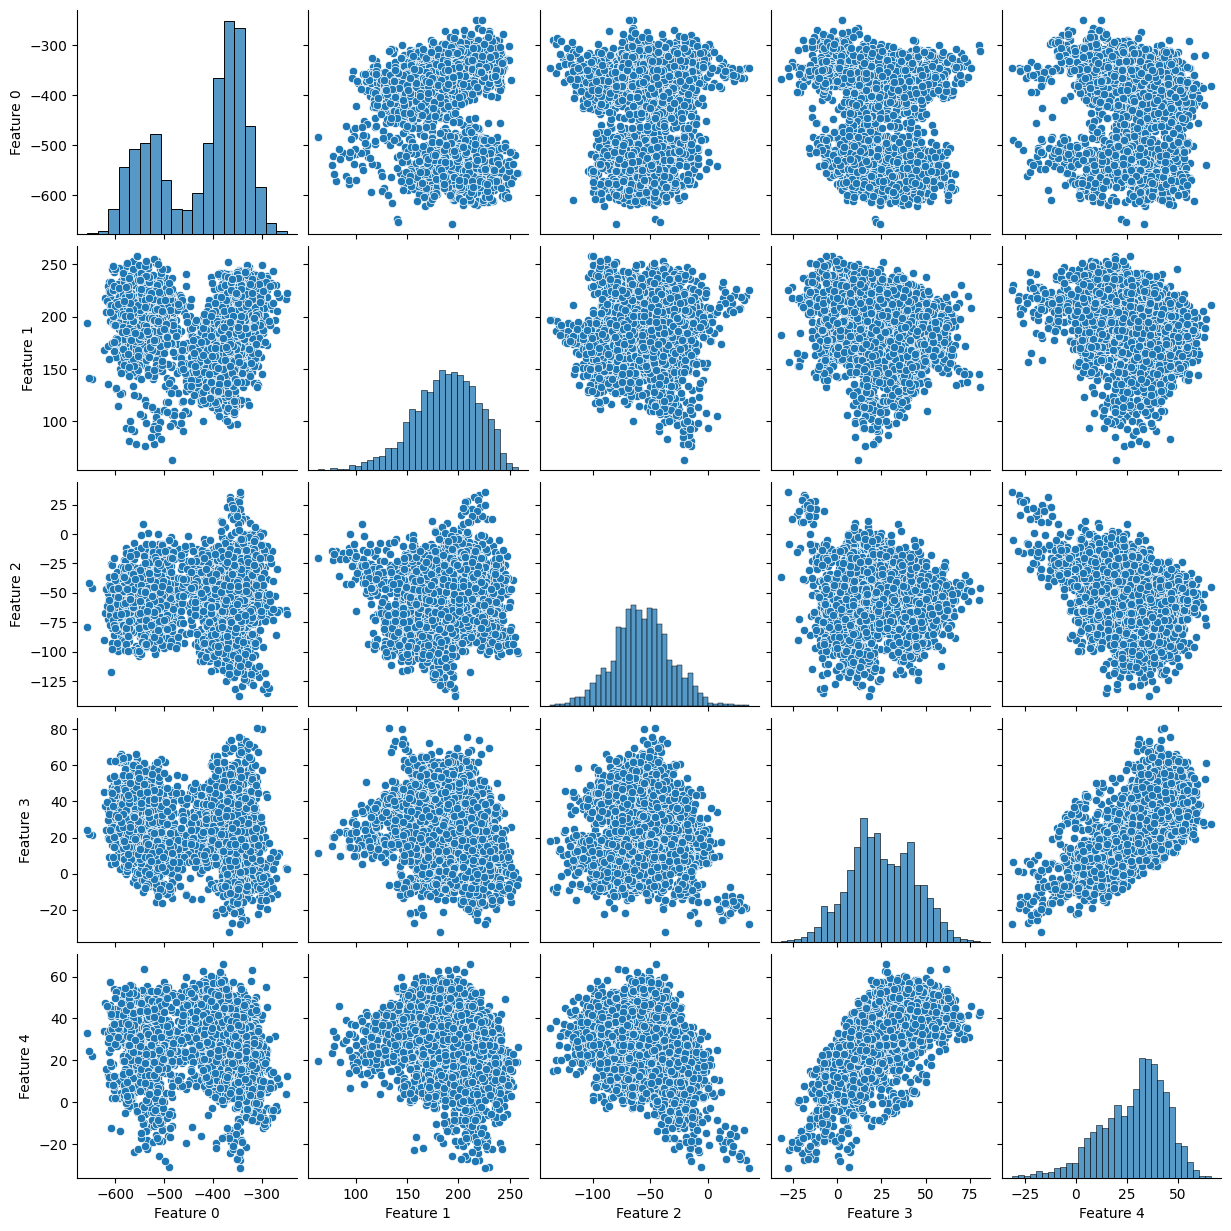

In [26]:
# Load the Data
unlabelled_data_path = "./data/unlabelled_sounds/"

audio_files = [f for f in os.listdir(unlabelled_data_path) if f.endswith(".wav")]

features = []

for audio_file in audio_files:
    signal, sr = librosa.load(unlabelled_data_path + audio_file)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs.T, axis=0))

feature_array = np.array(features)

plt.figure(figsize=(8, 6))
plt.scatter(feature_array[:, 0], feature_array[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Feature Distribution (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
sns.pairplot(
    pd.DataFrame(feature_array[:, :5], columns=[f"Feature {i}" for i in range(5)])
)
plt.show()

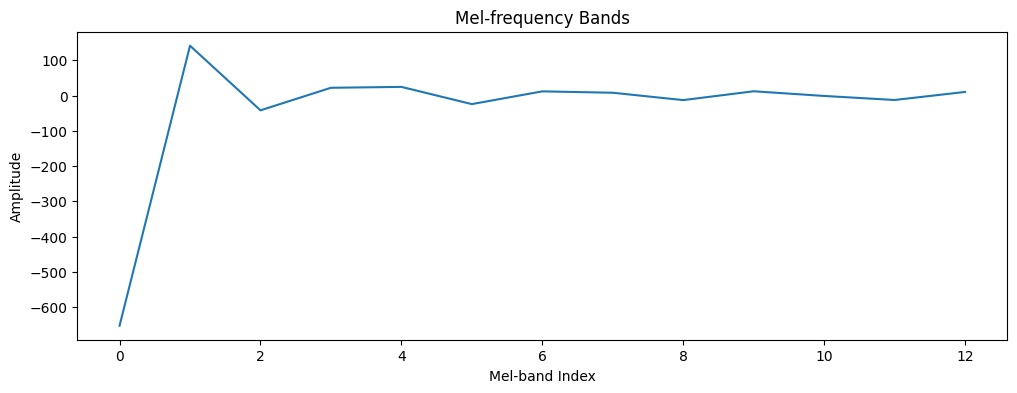

In [35]:
single_feature = feature_array[262]

plt.figure(figsize=(12, 4))
plt.plot(single_feature)
plt.title("Mel-frequency Bands")
plt.xlabel("Mel-band Index")
plt.ylabel("Amplitude")
plt.show()

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

When attempting to visualize the raw Mel spectrogram features, the scatter plot only shows 2 arbitrary dimensions, hiding most information. The pair plot becomes unreadable with many features, showing no clear patterns. It turns out that high-dimensional data suffers from the "curse of dimensionality" where points become equidistant, making clustering ineffective. Dimensionality reduction preserves meaningful structure while reducing noise and computational complexity.

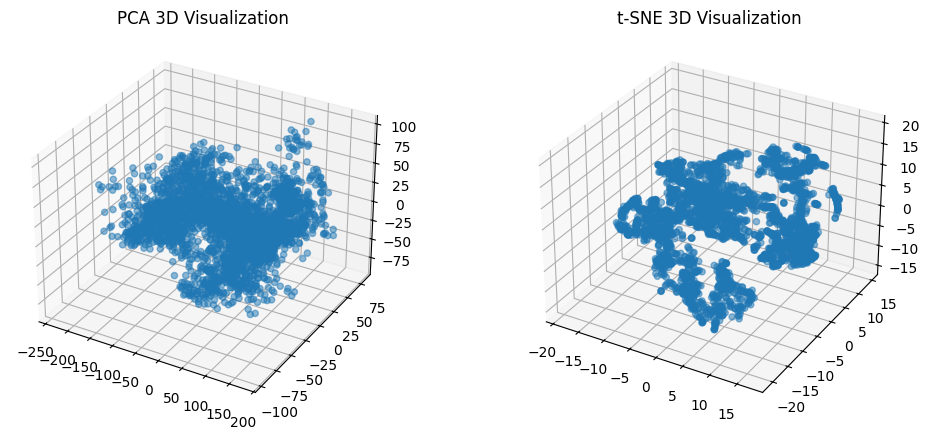

In [18]:
# Apply PCA (reduce to 3 components for 3D visualization)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(feature_array)

# Apply t-SNE (reduce to 3 components for visualization)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(feature_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 5))

# PCA 3D Visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax1.set_title("PCA 3D Visualization")

# t-SNE 3D Visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax2.set_title("t-SNE 3D Visualization")

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

t-SNE from my first image shows clearer cluster separation than PCA in this case because it specializes in preserving local neighborhood relationships in high-dim space. PCA which I visualized in the second image, maintains global variance but may collapse distinct clusters that are non-linear in the original space.

So, I'd personally say t-SNE did a better job at capturing the complex, non-linear relationships in the data, making the clusters easier to spot.

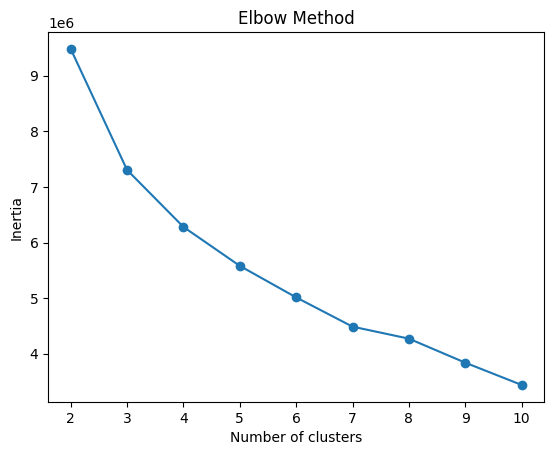

In [21]:
# Optimize number of clusters using Elbow Method
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  # Using PCA-reduced features
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

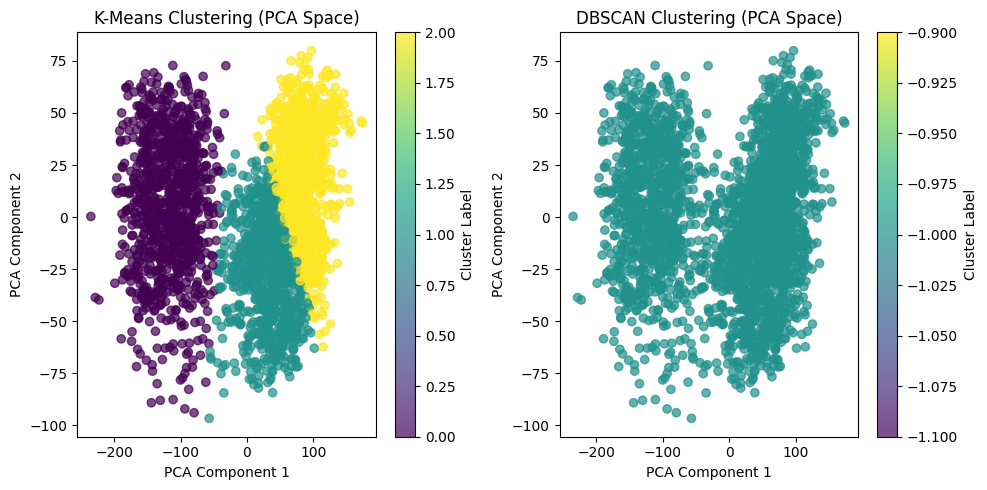

In [37]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering (PCA Space)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering (PCA Space)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()

In [23]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3808, Davies-Bouldin Index: 1.0606
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

Based on the results, K-Means clearly outperformed DBSCAN. With a decent silhouette score of 0.38 and a low Davies-Bouldin index of 1.06, K-Means formed well-separated and compact clusters. On the other hand, DBSCAN didn’t form any meaningful clusters, likely labeling most points as noise. From what I see, K-Means was just a better fit for the structure of this dataset.

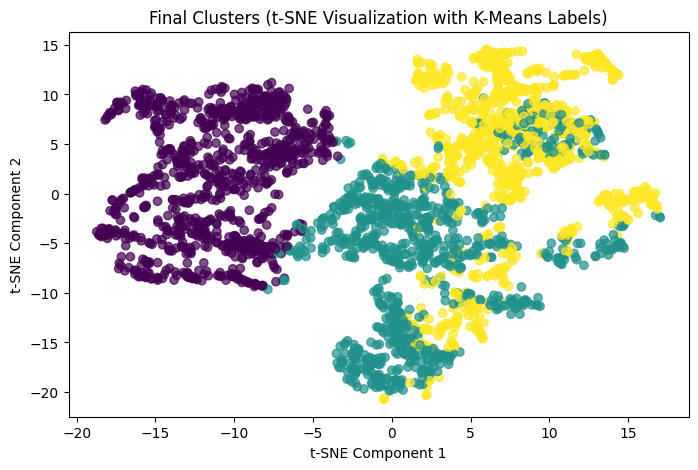

In [36]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.

 **Ans:** Dimensionality reduction improved clustering by projecting data to a lower-dimensional space where meaningful patterns became more visible and easier for clustering algorithm to detect.

- Justify why certain clustering methods worked better.

 **Ans:** K-Means worked better because the data had well-separated, compact groups that it could easily detect, while DBSCAN struggled to find meaningful clusters. most likely because the density differences weren't strong enough for it to work effectively.

- Relate findings to real-world clustering challenges.

 **Ans:** Real-world clustering requires preprocessing (like dimensionality reduction) and algorithm selection based on data characteristics - there's no universal best solution.


  Visualization of high-dim data is impossible without reduction

  Different reduction techniques reveal different patterns

  Algorithm performance depends on data structure

  Metrics help quantify what visualizations suggest